# <font color="blue">Battle of the Neighborhoods</font>
## Best location of a seafood restaurant in Paris, France
### *Julien DELMAS*
***

## <font color="blue">Introduction</font>

Expliquer le truc

Todo:  
- Faire une carte avec isprimarycategory  
- VOIR SI ON PEUT FAIRE DES REGRESSIONS

### Problem Statement

### Methodology

### Data collection

Le quartier désigne la division administrative de l’arrondissement. Chaque arrondissement est découpé
en quatre quartiers administratifs. Paris compte ainsi quatre-vingt quartiers administratifs.

https://en.wikipedia.org/wiki/Demographics_of_Paris#/media/File:Paris_Historical_Population.png

## <font color="blue">1. Initialization</font>

In this section we initialize some constants and we define some functions.

Private keys and tokens:

In [ ]:
# The code was removed by Watson Studio for sharing.

Project constants:

In [ ]:
#Foursquare
RESTAURANT_CATEGORY = 'seafood' #No space or special character
FOURSQUARE_CATEGORY = '4bf58dd8d48988d1ce941735' #Category for seafood restaurants, see https://developer.foursquare.com/docs/build-with-foursquare/categories/
FOURSQUARE_RADIUS = 1500 #Radius that should allow to cover every neighborhood
FOURSQUARE_LIMIT = 100 #Number of result per query
FOURSQUARE_UPDATE = True #Do we search the data in Foursquare or do we use the local data? This field is useful to avoid reaching the maximum queries per day

#Geography
PARIS_COORDINATES = [48.866667, 2.333333]

Code to access project resources like data sources, connections, and used by platform APIs

In [ ]:
from project_lib import Project
project = Project(project_id=PROJECT_ID, project_access_token=PROJECT_ACCESS_TOKEN)
pc = project.project_context

Define functions:

In [ ]:
def get_venues(latitude, longitude, category=FOURSQUARE_CATEGORY, radius=FOURSQUARE_RADIUS, limit=FOURSQUARE_LIMIT):
    """ 
    Obtain the list of venues around a certain position. 
    
    Parameters: 
        latitude (float): Latitude of the position.
        longitude (float): Longitude of the position.
        category (str): A comma-separated list of categories (see https://developer.foursquare.com/docs/build-with-foursquare/categories) to limit results to.
        radius (int): Limit results to venues within this many meters of the specified location. The maximum supported radius is currently 100,000 meters.
        limit (int): Number of results to return.
    
    Returns: 
        Dataframe: A dataframe with the list of venues in row and the following columns:
            id: A unique string identifier for this venue.
            Name: The best known name for this venue.
            Latitude: latitude of the venue.
            Longitude: longitude of the venue.
    """
    
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}&intent=browse'.format(
            FOURSQUARE_CLIENT_ID, 
            FOURSQUARE_CLIENT_SECRET, 
            FOURSQUARE_VERSION, 
            latitude, 
            longitude,
            category,
            radius, 
            limit)
    
    results = requests.get(url).json()
    
    venues = []
    for venue in results['response']['venues']:
        try:
            id = venue['id']
            name = venue['name']
            latitude = venue['location']['lat']
            longitude = venue['location']['lng']
            venues.append([id, name, latitude, longitude])
        except KeyError:
            pass
    
    columns = ['id', 'Name', 'Latitude', 'Longitude']
    
    df = pd.DataFrame(venues,columns=columns)
    return df


def get_venue_details(venue_id, category=None):
    """ 
    Obtain the details of a specific venue. 
    
    Parameters: 
        id (str): A unique string identifier for this venue.
        (optional) category (str): A Foursquare category (see https://developer.foursquare.com/docs/build-with-foursquare/categories) that will be used to populate the *IsPrimaryCategory* result.
    
    Returns: 
        Dict: A dictionary with the details of the venue:
            id (str): A unique string identifier for this venue.
            Name (str): The best known name for this venue.
            Price (int): price range from 1 (least pricey) to 4 (most pricey).
            PriceDescription (str): description of the Price result.
            Rating (float): Numerical rating of the venue (0 through 10). Not all venues will have a rating.
            Likes (int): Number of likes of the venue.
            TipsCount (int): NUmber of tips of the venue.
            IsPrimaryCategory (bool): True if the category input in parameters is the primary category of the venue, False oterwise. If the category is not passed as parameter, NaN is returned.
    """
    
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            FOURSQUARE_CLIENT_ID, 
            FOURSQUARE_CLIENT_SECRET, 
            FOURSQUARE_VERSION)

    results = requests.get(url).json()
    venue_data = results['response']['venue']
    
    try:
        name = venue_data['name']
    except KeyError:
        name = np.nan
    
    try:
        price = venue_data['price']['tier']
    except KeyError:
        price = np.nan
    
    try:
        price_description = venue_data['price']['message']
    except KeyError:
        price_description = np.nan
    
    try:
        rating = venue_data['rating']
    except KeyError:
        rating = np.nan
        
    try:
        likes = venue_data['likes']['count']
    except KeyError:
        likes = np.nan
    
    try:
        tips_count = venue_data['tips']['count']
    except KeyError:
        tips_count = np.nan
    
    try:
        if category is not None:
            is_primary_category = False
            for venue_category in venue_data['categories']:
                if venue_category['id'] == category and venue_category['primary'] is True:
                    is_primary_category = True
        else:
            is_primary_category = np.nan;
    except KeyError:
        is_primary_category = np.nan
        
    venue = {'id': venue_id, 'Name': name, 'Price': price, 'PriceDescription': price_description, 'Rating': rating, 'Likes': likes, 'TipsCount': tips_count, 'IsPrimaryCategory': is_primary_category}

    return venue

## <font color="blue">2. Data collection</font>

## Get data about Paris neighborhoods

### Import libraries

In [4]:
import pandas as pd
print('pandas library imported.')
import numpy as np
print('numpy library imported.')
import requests
print('requests library imported.')
from bs4 import BeautifulSoup
print('BeautifulSoup library imported.')
import json
print('json imported.')

print('All libraries imported.')

pandas library imported.
numpy library imported.
requests library imported.
BeautifulSoup library imported.
json imported.
All libraries imported.


### Get the data about neighborhoods of Paris

Get a csv from the site of the City of Paris: https://opendata.paris.fr/explore/dataset/quartier_paris/export/

In [5]:
!wget --quiet https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=csv -O paris_neighborhoods.csv

print('CSV file downloaded.')

CSV file downloaded.


In [6]:
paris_neighborhoods = pd.read_csv('paris_neighborhoods.csv', sep=';')

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods.dtypes))
paris_neighborhoods.head()

The dataframe shape is (80, 10).
The dataframe types are:
n_sq_qu        int64
c_qu           int64
c_quinsee      int64
l_qu          object
c_ar           int64
n_sq_ar        int64
perimetre    float64
surface      float64
geom_x_y      object
geom          object
dtype: object.


,n_sq_qu,c_qu,c_quinsee,l_qu,c_ar,n_sq_ar,perimetre,surface,geom_x_y,geom
0,750000036,36,7510904,Rochechouart,9,750000009,2862.450525,5.004354e+05,"48.8798119198,2.344861291","{""type"": ""Polygon"", ""coordinates"": [[[2.349708..."
1,750000047,47,7511203,Bercy,12,750000012,6155.005036,1.902932e+06,"48.8352090499,2.38621008421","{""type"": ""Polygon"", ""coordinates"": [[[2.391141..."
2,750000002,2,7510102,Halles,1,750000001,2606.417128,4.124585e+05,"48.8622891081,2.34489885831","{""type"": ""Polygon"", ""coordinates"": [[[2.349365..."
3,750000015,15,7510403,Arsenal,4,750000004,2878.559656,4.872649e+05,"48.851585175,2.36476795387","{""type"": ""Polygon"", ""coordinates"": [[[2.368512..."
4,750000018,18,7510502,Jardin-des-Plantes,5,750000005,4052.729521,7.983894e+05,"48.8419401934,2.35689388962","{""type"": ""Polygon"", ""coordinates"": [[[2.364561..."


In [7]:
project.save_data(file_name='paris_opendata.csv', data=paris_neighborhoods.to_csv(index=False), overwrite=True)

print('File paris_opendata.csv saved.')

File paris_opendata.csv saved.


### Cleaning the dataframe

Drop the columns we will not use

In [8]:
paris_neighborhoods.drop(['n_sq_qu', 'geom', 'n_sq_ar'], axis='columns', inplace=True)

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods.dtypes))
paris_neighborhoods.head()

The dataframe shape is (80, 7).
The dataframe types are:
c_qu           int64
c_quinsee      int64
l_qu          object
c_ar           int64
perimetre    float64
surface      float64
geom_x_y      object
dtype: object.


,c_qu,c_quinsee,l_qu,c_ar,perimetre,surface,geom_x_y
0,36,7510904,Rochechouart,9,2862.450525,5.004354e+05,"48.8798119198,2.344861291"
1,47,7511203,Bercy,12,6155.005036,1.902932e+06,"48.8352090499,2.38621008421"
2,2,7510102,Halles,1,2606.417128,4.124585e+05,"48.8622891081,2.34489885831"
3,15,7510403,Arsenal,4,2878.559656,4.872649e+05,"48.851585175,2.36476795387"
4,18,7510502,Jardin-des-Plantes,5,4052.729521,7.983894e+05,"48.8419401934,2.35689388962"


Rename the columns

In [9]:
paris_neighborhoods.columns = ['NeighborhoodNumber', 'NeighborhoodCode', 'Neighborhood', 'DistrictNumber', 'Perimeter', 'Area', 'Coordinates']

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods.dtypes))
paris_neighborhoods.head()

The dataframe shape is (80, 7).
The dataframe types are:
NeighborhoodNumber      int64
NeighborhoodCode        int64
Neighborhood           object
DistrictNumber          int64
Perimeter             float64
Area                  float64
Coordinates            object
dtype: object.


,NeighborhoodNumber,NeighborhoodCode,Neighborhood,DistrictNumber,Perimeter,Area,Coordinates
0,36,7510904,Rochechouart,9,2862.450525,5.004354e+05,"48.8798119198,2.344861291"
1,47,7511203,Bercy,12,6155.005036,1.902932e+06,"48.8352090499,2.38621008421"
2,2,7510102,Halles,1,2606.417128,4.124585e+05,"48.8622891081,2.34489885831"
3,15,7510403,Arsenal,4,2878.559656,4.872649e+05,"48.851585175,2.36476795387"
4,18,7510502,Jardin-des-Plantes,5,4052.729521,7.983894e+05,"48.8419401934,2.35689388962"


Split the coordinates in 2 columns

In [10]:
paris_neighborhoods[['Latitude', 'Longitude']] = paris_neighborhoods.Coordinates.str.split(",", expand=True)
paris_neighborhoods.drop(['Coordinates'], axis='columns', inplace=True)

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods.dtypes))
paris_neighborhoods.head()

The dataframe shape is (80, 8).
The dataframe types are:
NeighborhoodNumber      int64
NeighborhoodCode        int64
Neighborhood           object
DistrictNumber          int64
Perimeter             float64
Area                  float64
Latitude               object
Longitude              object
dtype: object.


,NeighborhoodNumber,NeighborhoodCode,Neighborhood,DistrictNumber,Perimeter,Area,Latitude,Longitude
0,36,7510904,Rochechouart,9,2862.450525,5.004354e+05,48.8798119198,2.344861291
1,47,7511203,Bercy,12,6155.005036,1.902932e+06,48.8352090499,2.38621008421
2,2,7510102,Halles,1,2606.417128,4.124585e+05,48.8622891081,2.34489885831
3,15,7510403,Arsenal,4,2878.559656,4.872649e+05,48.851585175,2.36476795387
4,18,7510502,Jardin-des-Plantes,5,4052.729521,7.983894e+05,48.8419401934,2.35689388962


Convert area to square kilometers

In [11]:
paris_neighborhoods[['Area']] = paris_neighborhoods[['Area']]/1e6

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods.dtypes))
paris_neighborhoods.head()

The dataframe shape is (80, 8).
The dataframe types are:
NeighborhoodNumber      int64
NeighborhoodCode        int64
Neighborhood           object
DistrictNumber          int64
Perimeter             float64
Area                  float64
Latitude               object
Longitude              object
dtype: object.


,NeighborhoodNumber,NeighborhoodCode,Neighborhood,DistrictNumber,Perimeter,Area,Latitude,Longitude
0,36,7510904,Rochechouart,9,2862.450525,0.500435,48.8798119198,2.344861291
1,47,7511203,Bercy,12,6155.005036,1.902932,48.8352090499,2.38621008421
2,2,7510102,Halles,1,2606.417128,0.412458,48.8622891081,2.34489885831
3,15,7510403,Arsenal,4,2878.559656,0.487265,48.851585175,2.36476795387
4,18,7510502,Jardin-des-Plantes,5,4052.729521,0.798389,48.8419401934,2.35689388962


Get more information from Wikipedia
Scrape the wikipedia page about the neighborhoods of Paris: https://en.wikipedia.org/wiki/Quarters_of_Paris

In [12]:
result = requests.get("https://en.wikipedia.org/wiki/Quarters_of_Paris")
soup = BeautifulSoup(result.content,'lxml')
table = soup.find_all('table')[0] 
paris_neighborhoods_wikipedia = pd.read_html(str(table))[0]

print('The dataframe shape is {}.'.format(paris_neighborhoods_wikipedia.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods_wikipedia.dtypes))
paris_neighborhoods_wikipedia.head()

The dataframe shape is (80, 6).
The dataframe types are:
Arrondissement(Districts)     object
Quartiers(Quarters)           object
Quartiers(Quarters).1         object
Population in1999[3]           int64
Area(hectares)[3]            float64
Map                          float64
dtype: object.


,Arrondissement(Districts),Quartiers(Quarters),Quartiers(Quarters).1,Population in1999[3],Area(hectares)[3],Map
0,"1st arrondissement(Called ""du Louvre"")",1st,Saint-Germain-l'Auxerrois,1672,86.9,NaN
1,"1st arrondissement(Called ""du Louvre"")",2nd,Les Halles,8984,41.2,NaN
2,"1st arrondissement(Called ""du Louvre"")",3rd,Palais-Royal,3195,27.4,NaN
3,"1st arrondissement(Called ""du Louvre"")",4th,Place-Vendôme,3044,26.9,NaN
4,"2nd arrondissement(Called ""de la Bourse"")",5th,Gaillon,1345,18.8,NaN


Drop the columns we will not use

In [13]:
paris_neighborhoods_wikipedia.drop(['Quartiers(Quarters).1', 'Area(hectares)[3]', 'Map'], axis='columns', inplace=True)

print('The dataframe shape is {}.'.format(paris_neighborhoods_wikipedia.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods_wikipedia.dtypes))
paris_neighborhoods_wikipedia.head()

The dataframe shape is (80, 3).
The dataframe types are:
Arrondissement(Districts)    object
Quartiers(Quarters)          object
Population in1999[3]          int64
dtype: object.


,Arrondissement(Districts),Quartiers(Quarters),Population in1999[3]
0,"1st arrondissement(Called ""du Louvre"")",1st,1672
1,"1st arrondissement(Called ""du Louvre"")",2nd,8984
2,"1st arrondissement(Called ""du Louvre"")",3rd,3195
3,"1st arrondissement(Called ""du Louvre"")",4th,3044
4,"2nd arrondissement(Called ""de la Bourse"")",5th,1345


Rename the columns

In [14]:
paris_neighborhoods_wikipedia.columns = ['District', 'NeighborhoodNumber', 'Population']

print('The dataframe shape is {}.'.format(paris_neighborhoods_wikipedia.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods_wikipedia.dtypes))
paris_neighborhoods_wikipedia.head()

The dataframe shape is (80, 3).
The dataframe types are:
District              object
NeighborhoodNumber    object
Population             int64
dtype: object.


,District,NeighborhoodNumber,Population
0,"1st arrondissement(Called ""du Louvre"")",1st,1672
1,"1st arrondissement(Called ""du Louvre"")",2nd,8984
2,"1st arrondissement(Called ""du Louvre"")",3rd,3195
3,"1st arrondissement(Called ""du Louvre"")",4th,3044
4,"2nd arrondissement(Called ""de la Bourse"")",5th,1345


Split the district official name (number of the "arrondissement") and the "also called" named (which is not commonly used in Paris)

In [15]:
paris_neighborhoods_wikipedia[['District', 'DistrictName']] = paris_neighborhoods_wikipedia.District.str.split("(",expand=True,)

print('The dataframe shape is {}.'.format(paris_neighborhoods_wikipedia.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods_wikipedia.dtypes))
paris_neighborhoods_wikipedia.head()

The dataframe shape is (80, 4).
The dataframe types are:
District              object
NeighborhoodNumber    object
Population             int64
DistrictName          object
dtype: object.


,District,NeighborhoodNumber,Population,DistrictName
0,1st arrondissement,1st,1672,"Called ""du Louvre"")"
1,1st arrondissement,2nd,8984,"Called ""du Louvre"")"
2,1st arrondissement,3rd,3195,"Called ""du Louvre"")"
3,1st arrondissement,4th,3044,"Called ""du Louvre"")"
4,2nd arrondissement,5th,1345,"Called ""de la Bourse"")"


Make the district name more beautiful

In [16]:
paris_neighborhoods_wikipedia[['DistrictName']] = paris_neighborhoods_wikipedia.DistrictName.str.replace('Called \"', 'Arrondissement ')
paris_neighborhoods_wikipedia[['DistrictName']] = paris_neighborhoods_wikipedia.DistrictName.str.replace("\"\)", '')

print('The dataframe shape is {}.'.format(paris_neighborhoods_wikipedia.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods_wikipedia.dtypes))
paris_neighborhoods_wikipedia.head()

The dataframe shape is (80, 4).
The dataframe types are:
District              object
NeighborhoodNumber    object
Population             int64
DistrictName          object
dtype: object.


,District,NeighborhoodNumber,Population,DistrictName
0,1st arrondissement,1st,1672,Arrondissement du Louvre
1,1st arrondissement,2nd,8984,Arrondissement du Louvre
2,1st arrondissement,3rd,3195,Arrondissement du Louvre
3,1st arrondissement,4th,3044,Arrondissement du Louvre
4,2nd arrondissement,5th,1345,Arrondissement de la Bourse


Remove letters from the neighborhood code

In [17]:
paris_neighborhoods_wikipedia[['NeighborhoodNumber']] = paris_neighborhoods_wikipedia.NeighborhoodNumber.str[:-2]
paris_neighborhoods_wikipedia = paris_neighborhoods_wikipedia.astype({'NeighborhoodNumber': int})

print('The dataframe shape is {}.'.format(paris_neighborhoods_wikipedia.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods_wikipedia.dtypes))
paris_neighborhoods_wikipedia.head()

The dataframe shape is (80, 4).
The dataframe types are:
District              object
NeighborhoodNumber     int64
Population             int64
DistrictName          object
dtype: object.


,District,NeighborhoodNumber,Population,DistrictName
0,1st arrondissement,1,1672,Arrondissement du Louvre
1,1st arrondissement,2,8984,Arrondissement du Louvre
2,1st arrondissement,3,3195,Arrondissement du Louvre
3,1st arrondissement,4,3044,Arrondissement du Louvre
4,2nd arrondissement,5,1345,Arrondissement de la Bourse


In [18]:
paris_neighborhoods = pd.merge(paris_neighborhoods, paris_neighborhoods_wikipedia, on='NeighborhoodNumber')

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods.dtypes))
paris_neighborhoods.head()

The dataframe shape is (80, 11).
The dataframe types are:
NeighborhoodNumber      int64
NeighborhoodCode        int64
Neighborhood           object
DistrictNumber          int64
Perimeter             float64
Area                  float64
Latitude               object
Longitude              object
District               object
Population              int64
DistrictName           object
dtype: object.


,NeighborhoodNumber,NeighborhoodCode,Neighborhood,DistrictNumber,Perimeter,Area,Latitude,Longitude,District,Population,DistrictName
0,36,7510904,Rochechouart,9,2862.450525,0.500435,48.8798119198,2.344861291,9th arrondissement,22212,Arrondissement de l'Opéra
1,47,7511203,Bercy,12,6155.005036,1.902932,48.8352090499,2.38621008421,12th arrondissement,13987,Arrondissement de Reuilly
2,2,7510102,Halles,1,2606.417128,0.412458,48.8622891081,2.34489885831,1st arrondissement,8984,Arrondissement du Louvre
3,15,7510403,Arsenal,4,2878.559656,0.487265,48.851585175,2.36476795387,4th arrondissement,9474,Arrondissement de l'Hôtel-de-Ville
4,18,7510502,Jardin-des-Plantes,5,4052.729521,0.798389,48.8419401934,2.35689388962,5th arrondissement,18005,Arrondissement du Panthéon


Add the postal code

In [ ]:
paris_neighborhoods['PostalCode'] = '750' + paris_neighborhoods.District.str.split(' ').str[0].str[:-2].str.rjust(2, '0')

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods.dtypes))
paris_neighborhoods.head()

The dataframe shape is (80, 12).
The dataframe types are:
NeighborhoodNumber      int64
NeighborhoodCode        int64
Neighborhood           object
DistrictNumber          int64
Perimeter             float64
Area                  float64
Latitude               object
Longitude              object
District               object
Population              int64
DistrictName           object
PostalCode             object
dtype: object.


,NeighborhoodNumber,NeighborhoodCode,Neighborhood,DistrictNumber,Perimeter,Area,Latitude,Longitude,District,Population,DistrictName,PostalCode
0,36,7510904,Rochechouart,9,2862.450525,0.500435,48.8798119198,2.344861291,9th arrondissement,22212,Arrondissement de l'Opéra,75009
1,47,7511203,Bercy,12,6155.005036,1.902932,48.8352090499,2.38621008421,12th arrondissement,13987,Arrondissement de Reuilly,75012
2,2,7510102,Halles,1,2606.417128,0.412458,48.8622891081,2.34489885831,1st arrondissement,8984,Arrondissement du Louvre,75001
3,15,7510403,Arsenal,4,2878.559656,0.487265,48.851585175,2.36476795387,4th arrondissement,9474,Arrondissement de l'Hôtel-de-Ville,75004
4,18,7510502,Jardin-des-Plantes,5,4052.729521,0.798389,48.8419401934,2.35689388962,5th arrondissement,18005,Arrondissement du Panthéon,75005


Reorganize columns

In [ ]:
paris_neighborhoods = paris_neighborhoods[['NeighborhoodCode', 'NeighborhoodNumber', 'Neighborhood', 'DistrictNumber', 'District', 'DistrictName', 'PostalCode', 'Population', 'Area', 'Perimeter', 'Latitude', 'Longitude']]

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods.dtypes))
paris_neighborhoods.head()

The dataframe shape is (80, 12).
The dataframe types are:
NeighborhoodCode        int64
NeighborhoodNumber      int64
Neighborhood           object
DistrictNumber          int64
District               object
DistrictName           object
PostalCode             object
Population              int64
Area                  float64
Perimeter             float64
Latitude               object
Longitude              object
dtype: object.


,NeighborhoodCode,NeighborhoodNumber,Neighborhood,DistrictNumber,District,DistrictName,PostalCode,Population,Area,Perimeter,Latitude,Longitude
0,7510904,36,Rochechouart,9,9th arrondissement,Arrondissement de l'Opéra,75009,22212,0.500435,2862.450525,48.8798119198,2.344861291
1,7511203,47,Bercy,12,12th arrondissement,Arrondissement de Reuilly,75012,13987,1.902932,6155.005036,48.8352090499,2.38621008421
2,7510102,2,Halles,1,1st arrondissement,Arrondissement du Louvre,75001,8984,0.412458,2606.417128,48.8622891081,2.34489885831
3,7510403,15,Arsenal,4,4th arrondissement,Arrondissement de l'Hôtel-de-Ville,75004,9474,0.487265,2878.559656,48.851585175,2.36476795387
4,7510502,18,Jardin-des-Plantes,5,5th arrondissement,Arrondissement du Panthéon,75005,18005,0.798389,4052.729521,48.8419401934,2.35689388962


Cast PostalCode and NeighborhoodCode columns to integer

In [ ]:
paris_neighborhoods = paris_neighborhoods.astype({'PostalCode': int, 'Latitude': float, 'Longitude': float})

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods.dtypes))
paris_neighborhoods.head()

The dataframe shape is (80, 12).
The dataframe types are:
NeighborhoodCode        int64
NeighborhoodNumber      int64
Neighborhood           object
DistrictNumber          int64
District               object
DistrictName           object
PostalCode              int64
Population              int64
Area                  float64
Perimeter             float64
Latitude              float64
Longitude             float64
dtype: object.


,NeighborhoodCode,NeighborhoodNumber,Neighborhood,DistrictNumber,District,DistrictName,PostalCode,Population,Area,Perimeter,Latitude,Longitude
0,7510904,36,Rochechouart,9,9th arrondissement,Arrondissement de l'Opéra,75009,22212,0.500435,2862.450525,48.879812,2.344861
1,7511203,47,Bercy,12,12th arrondissement,Arrondissement de Reuilly,75012,13987,1.902932,6155.005036,48.835209,2.386210
2,7510102,2,Halles,1,1st arrondissement,Arrondissement du Louvre,75001,8984,0.412458,2606.417128,48.862289,2.344899
3,7510403,15,Arsenal,4,4th arrondissement,Arrondissement de l'Hôtel-de-Ville,75004,9474,0.487265,2878.559656,48.851585,2.364768
4,7510502,18,Jardin-des-Plantes,5,5th arrondissement,Arrondissement du Panthéon,75005,18005,0.798389,4052.729521,48.841940,2.356894


In [ ]:
project.save_data(file_name='paris_neighborhoods.csv', data=paris_neighborhoods.to_csv(index=False), overwrite=True)

print('File paris_neighborhoods.csv saved.')

File paris_neighborhoods.csv saved.


## Some visual analysis of the neighborhoods

### Choropleth map

In [ ]:
try:
    import folium
except:
    print('folium not installed, installing folium.')
    !conda install -c conda-forge folium
    print('folium installed.')
    import folium
print('folium imported.')

print('All libraries imported.')

folium not installed, installing folium.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.10.1              |             py_0          59 KB  conda-forge

The following NEW packages will be INSTALLED:

    branca:  0.4.0-py_0  conda-forge
    folium:  0.10.1-py_0 conda-forge
    vincent: 0.4.4-py_1  conda-forge


folium-0.10.1        | 59 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
folium installed.
folium imported.
All libraries imported.


In [ ]:
!wget --quiet https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=geojson -O paris_neighborhoods_geo.json

print('GeoJSON file downloaded.')

with open('paris_neighborhoods_geo.json') as geojson:
    paris_neighborhoods_geo = json.load(geojson)
project.save_data(file_name='paris_neighborhoods_geo.json', data=json.dumps(paris_neighborhoods_geo), overwrite=True)
print('File paris_neighborhoods_geo.json saved.')

GeoJSON file downloaded.
File paris_neighborhoods_geo.json saved.


In [ ]:
paris_neighborhoods_geo = r'paris_neighborhoods_geo.json'

In [ ]:
paris_map = folium.Map(location=PARIS_COORDINATES, zoom_start=13, tiles='OpenStreetMap')

choropleth = folium.Choropleth(
    geo_data=paris_neighborhoods_geo,
    data=paris_neighborhoods,
    columns=['NeighborhoodCode', 'Population'],
    key_on='feature.properties.c_quinsee',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Neighborhoods of Paris by population in 1999'
).add_to(paris_map)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['l_qu'],labels=False)
).add_to(paris_map)

paris_map

### Scatter plot

In [ ]:
import matplotlib.pyplot as plt
print('matplotlib.pyplot library imported.')
import matplotlib.image as mpimg
print('matplotlib.image library imported.')

print('All libraries imported.')

matplotlib.pyplot library imported.
matplotlib.image library imported.
All libraries imported.


In [ ]:
scatter_plot_df = paris_neighborhoods[['Neighborhood', 'Population', 'Area']].copy()

print('The dataframe shape is {}.'.format(scatter_plot_df.shape))
print('The dataframe types are:\n{}.'.format(scatter_plot_df.dtypes))
scatter_plot_df.head()

The dataframe shape is (80, 3).
The dataframe types are:
Neighborhood     object
Population        int64
Area            float64
dtype: object.


,Neighborhood,Population,Area
0,Rochechouart,22212,0.500435
1,Bercy,13987,1.902932
2,Halles,8984,0.412458
3,Arsenal,9474,0.487265
4,Jardin-des-Plantes,18005,0.798389


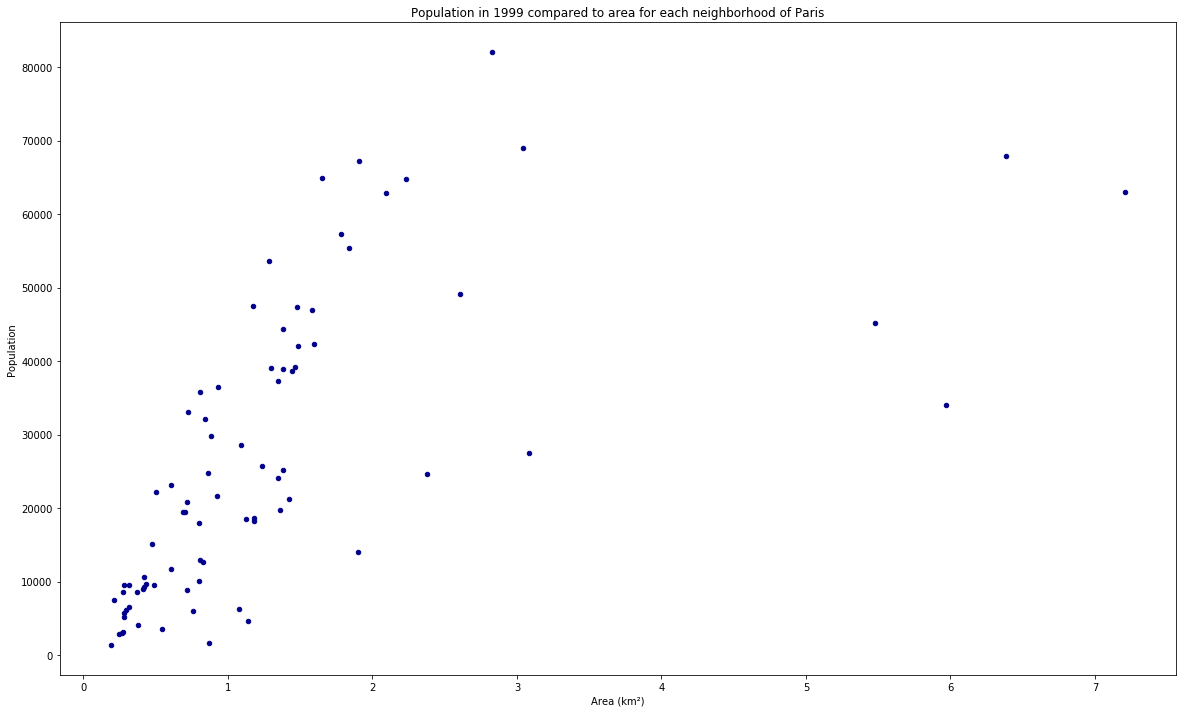

In [ ]:
scatter_plot_df.plot(kind='scatter', x='Area', y='Population', figsize=(20, 12), color='darkblue')

plt.title('Population in 1999 compared to area for each neighborhood of Paris')
plt.xlabel('Area (km²)')
plt.ylabel('Population')

plt.show()

In [ ]:
bar_chart_df = paris_neighborhoods[['Neighborhood', 'District', 'Population', 'Area']].copy()
bar_chart_df.set_index(['District', 'Neighborhood'], inplace=True)

bar_chart_df['Density'] = bar_chart_df['Population'] / bar_chart_df['Area']

print('The dataframe shape is {}.'.format(bar_chart_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_df.dtypes))
bar_chart_df.head()

The dataframe shape is (80, 3).
The dataframe types are:
Population      int64
Area          float64
Density       float64
dtype: object.


,,Population,Area,Density
District,Neighborhood,,,
9th arrondissement,Rochechouart,22212,0.500435,44385.347911
12th arrondissement,Bercy,13987,1.902932,7350.235593
1st arrondissement,Halles,8984,0.412458,21781.585493
4th arrondissement,Arsenal,9474,0.487265,19443.221293
5th arrondissement,Jardin-des-Plantes,18005,0.798389,22551.652157


In [ ]:
bar_chart_neighborhood_df = bar_chart_df[['Density']].sort_values(by=['Density'], ascending=True)

print('The dataframe shape is {}.'.format(bar_chart_neighborhood_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_neighborhood_df.dtypes))
bar_chart_neighborhood_df.head()

The dataframe shape is (80, 1).
The dataframe types are:
Density    float64
dtype: object.


,,Density
District,Neighborhood,
1st arrondissement,Saint-Germain-l'Auxerrois,1924.049162
8th arrondissement,Champs-Elysées,4046.466869
12th arrondissement,Bel-Air,5690.244910
7th arrondissement,Invalides,5845.024327
9th arrondissement,Chaussée-d'Antin,6418.358062


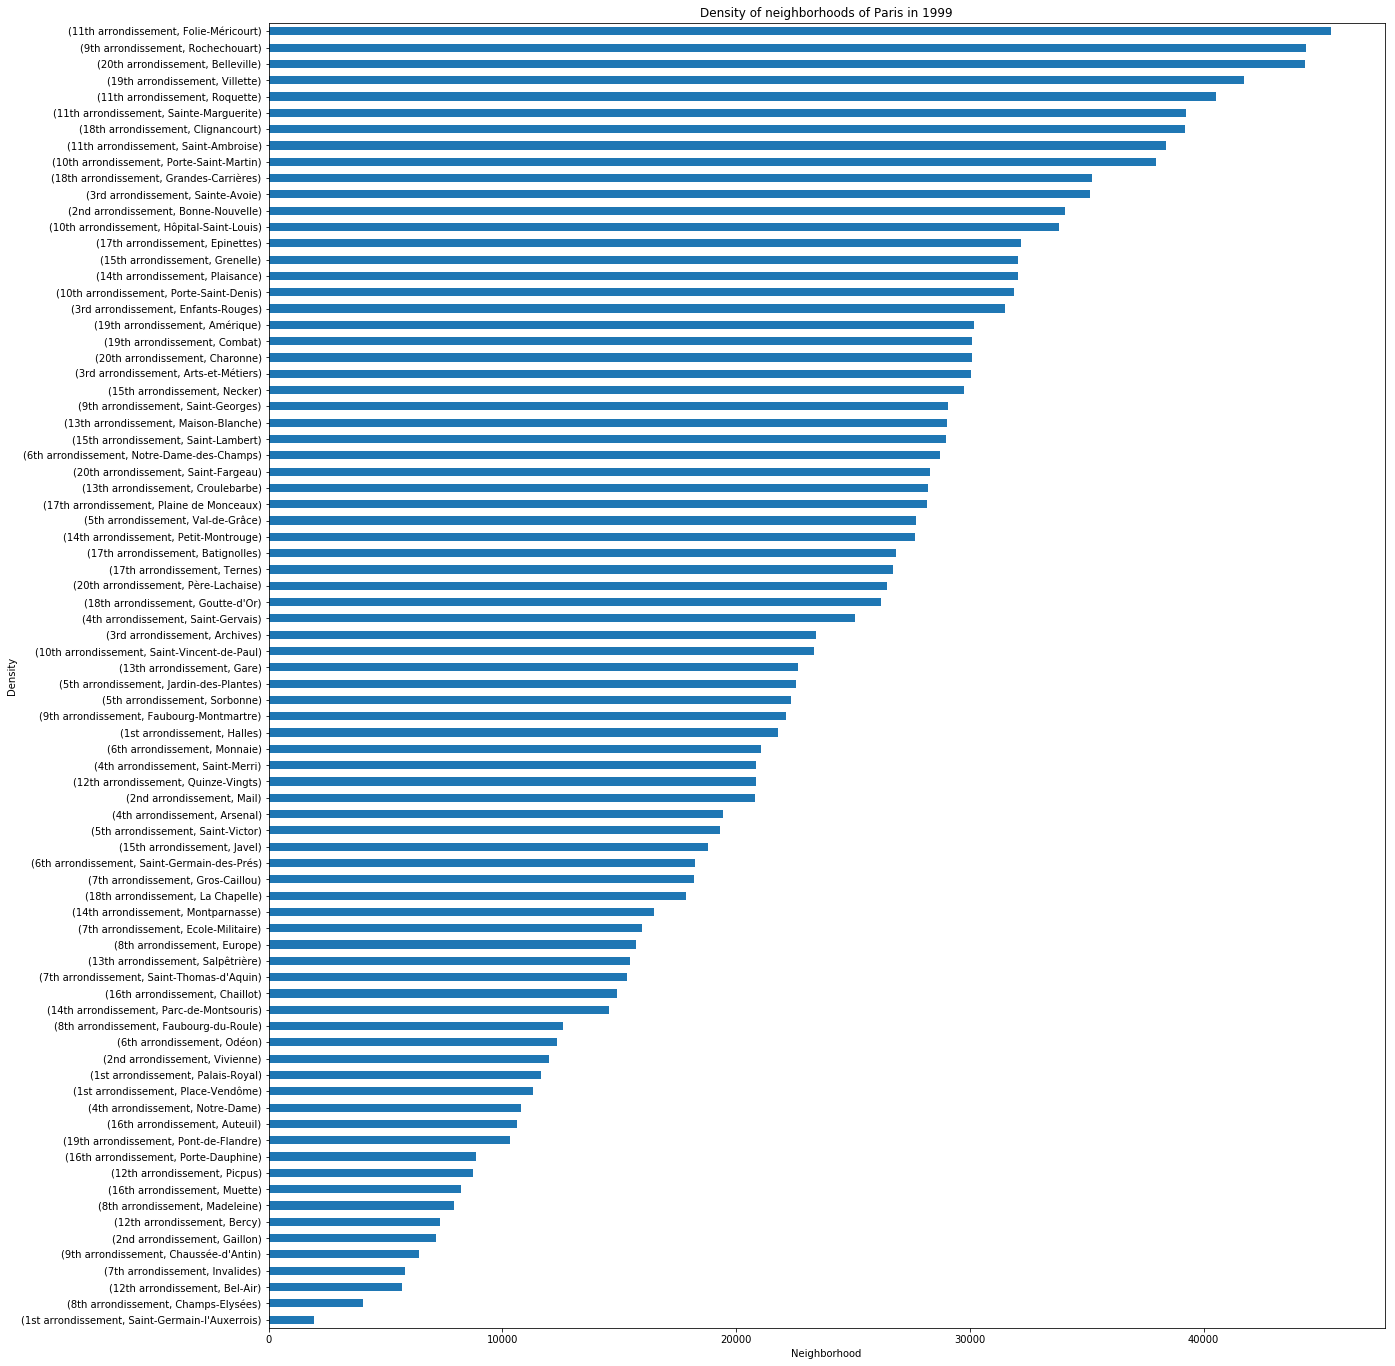

In [ ]:
bar_chart_neighborhood_df.plot(kind='barh', figsize=(20, 24))

plt.xlabel('Neighborhood')
plt.ylabel('Density')
plt.title('Density of neighborhoods of Paris in 1999')
plt.legend().remove()

plt.show()

In [ ]:
bar_chart_district_df = bar_chart_df.groupby('District').sum()
bar_chart_district_df['Density'] = bar_chart_district_df['Population'] / bar_chart_district_df['Area']
bar_chart_district_df = bar_chart_district_df[['Density']].sort_values(by=['Density'], ascending=True)

print('The dataframe shape is {}.'.format(bar_chart_district_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_district_df.dtypes))
bar_chart_district_df.head()

The dataframe shape is (20, 1).
The dataframe types are:
Density    float64
dtype: object.


,Density
District,
12th arrondissement,8376.574893
1st arrondissement,9259.499113
16th arrondissement,9883.439126
8th arrondissement,10129.543710
7th arrondissement,13933.301305


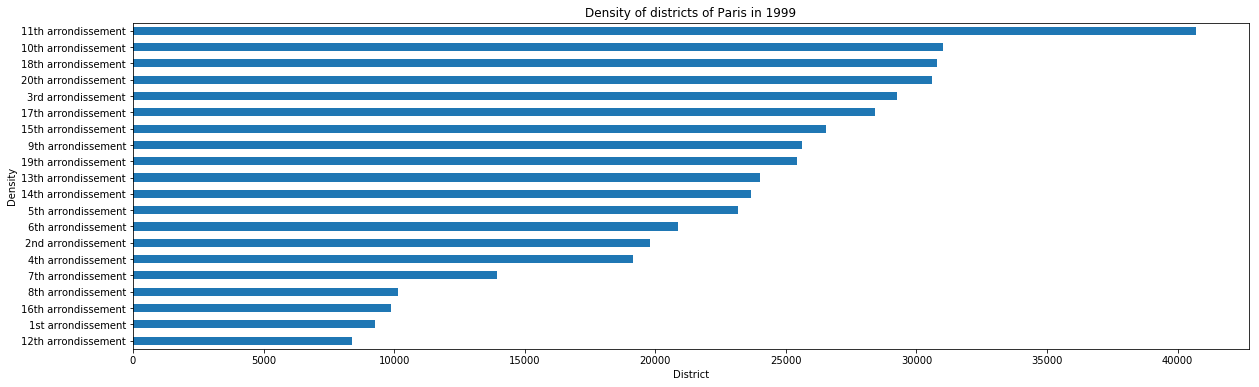

In [ ]:
bar_chart_district_df.plot(kind='barh', figsize=(20, 6))

plt.xlabel('District')
plt.ylabel('Density')
plt.title('Density of districts of Paris in 1999')
plt.legend().remove()

plt.show()

## Analyse the localisation of restaurants

In [ ]:
restaurants_foursquare = None

if FOURSQUARE_UPDATE:
    for id, neighborhood in paris_neighborhoods.iterrows():
        restaurants_neighborhood = get_venues(neighborhood['Latitude'], neighborhood['Longitude'])
        restaurants_foursquare = pd.concat([restaurants_foursquare, restaurants_neighborhood], ignore_index=True, sort=False)
    restaurants_foursquare.drop_duplicates(subset='id', keep='first', inplace=True) 
    project.save_data(file_name='restaurants_foursquare.csv', data=restaurants_foursquare.to_csv(index=False), overwrite=True)
    print('File restaurants_foursquare.csv saved.')
else:
    restaurants_foursquare_file = project.get_file('restaurants_foursquare.csv')
    restaurants_foursquare = pd.read_csv(restaurants_foursquare_file)
    print('File restaurants_foursquare.csv loaded.')

print('The dataframe shape is {}.'.format(restaurants_foursquare.shape))
print('The dataframe types are:\n{}.'.format(restaurants_foursquare.dtypes))
restaurants_foursquare.head()

File restaurants_foursquare.csv saved.
The dataframe shape is (189, 4).
The dataframe types are:
id            object
Name          object
Latitude     float64
Longitude    float64
dtype: object.


,id,Name,Latitude,Longitude
0,4ea456aa61af76b39d5803a1,La Belle de Liron,48.866846,2.347244
1,4b5ff171f964a5204cd129e3,Nautilus Food,48.872344,2.342870
2,4bd2011c046076b0bb017371,Léon de Bruxelles,48.883684,2.327870
3,4b8137c8f964a520e09a30e3,La Criée,48.870531,2.348942
4,56b8e71c498e33f2f695cd55,Restaurant Le Sichuan,48.870730,2.355052


In [ ]:
restaurants_foursquare.describe()

,Latitude,Longitude
count,189.000000,189.000000
mean,48.861465,2.330261
std,0.016912,0.031417
min,48.815160,2.239556
25%,48.850952,2.313317
50%,48.862078,2.333255
75%,48.874305,2.351608
max,48.902006,2.407587


In [ ]:
try:
    from shapely.geometry import Point, shape
except:
    print('shapely not installed, installing folium.')
    !conda install -c conda-forge shapely
    print('shapely installed.')
    from shapely.geometry import Point, shape
print('shapely.geometry imported.')

print('All libraries imported.')

shapely not installed, installing folium.
Solving environment: / 

In [ ]:
restaurants_paris = pd.DataFrame(columns=['id', 'Name', 'Latitude', 'Longitude', 'NeighborhoodCode'])

paris_neighborhoods_geo_file = project.get_file('paris_neighborhoods_geo.json')
paris_neighborhoods_geo = pd.read_json(paris_neighborhoods_geo_file)
print('File paris_neighborhoods_geo.json loaded.')

for id, restaurant in restaurants_foursquare.iterrows():
    restaurant_location = Point(restaurant['Longitude'], restaurant['Latitude'])

    for feature in paris_neighborhoods_geo['features']:
        neighborhood = shape(feature['geometry'])
        if restaurant_location.within(neighborhood):
            restaurants_paris = restaurants_paris.append({'id': restaurant['id'], 'Name': restaurant['Name'], 'Latitude': restaurant['Latitude'], 'Longitude': restaurant['Longitude'], 'NeighborhoodCode': feature['properties']['c_quinsee']}, ignore_index=True, sort=False)
            break

print('The dataframe shape is {}.'.format(restaurants_paris.shape))
print('The dataframe types are:\n{}.'.format(restaurants_paris.dtypes))
restaurants_paris.head()

In [ ]:
project.save_data(file_name=RESTAURANT_CATEGORY+'_restaurants_paris.csv', data=restaurants_paris.to_csv(index=False), overwrite=True)
print('File ' + RESTAURANT_CATEGORY + '_restaurants_paris.csv saved.')

In [ ]:
restaurants_map = folium.map.FeatureGroup()

for latitude, longitude, name in restaurants_paris[['Latitude', 'Longitude', 'Name']].values:
    restaurants_map.add_child(
        folium.CircleMarker(
            [latitude, longitude],
            radius=5,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            popup=name
        )
    )
    
paris_map.add_child(restaurants_map)

paris_map

In [ ]:
bar_chart_df = pd.merge(paris_neighborhoods[['NeighborhoodCode', 'Neighborhood', 'District',]], restaurants_paris[['NeighborhoodCode', 'id']], on='NeighborhoodCode', how='outer')
bar_chart_df.drop(['NeighborhoodCode'], axis='columns', inplace=True)
bar_chart_df.set_index(['District', 'Neighborhood'], inplace=True)

print('The dataframe shape is {}.'.format(bar_chart_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_df.dtypes))
bar_chart_df.head()

In [ ]:
bar_chart_neighborhood_df = bar_chart_df.groupby(['District', 'Neighborhood']).count()
bar_chart_neighborhood_df.rename(columns={'id': 'RestaurantsCount'}, inplace=True)
bar_chart_neighborhood_df = bar_chart_neighborhood_df.sort_values(by=['RestaurantsCount'], ascending=True)

print('The dataframe shape is {}.'.format(bar_chart_neighborhood_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_neighborhood_df.dtypes))
bar_chart_neighborhood_df.head()

In [ ]:
bar_chart_neighborhood_df.plot(kind='barh', figsize=(20, 24))

plt.xlabel('Number of ' + RESTAURANT_CATEGORY + ' restaurants')
plt.ylabel('Neighborhood')
plt.title('Number of ' + RESTAURANT_CATEGORY + ' restaurants per neighborhood')
plt.legend().remove()

plt.show()

In [ ]:
bar_chart_neighborhood_df2 = pd.merge(bar_chart_neighborhood_df, paris_neighborhoods, on='Neighborhood')
bar_chart_neighborhood_df2 = bar_chart_neighborhood_df2[['Neighborhood', 'RestaurantsCount', 'District', 'Population']]
bar_chart_neighborhood_df2['RestaurantsPerMillionInhabitants'] = bar_chart_neighborhood_df2['RestaurantsCount'] / bar_chart_neighborhood_df2['Population'] * 1e6
bar_chart_neighborhood_df2 = bar_chart_neighborhood_df2[['Neighborhood', 'RestaurantsPerMillionInhabitants', 'District']]
bar_chart_neighborhood_df2.set_index(['District', 'Neighborhood'], inplace=True)
bar_chart_neighborhood_df2 = bar_chart_neighborhood_df2.sort_values(by=['RestaurantsPerMillionInhabitants'], ascending=True)

print('The dataframe shape is {}.'.format(bar_chart_neighborhood_df2.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_neighborhood_df2.dtypes))
bar_chart_neighborhood_df2.head()

In [ ]:
bar_chart_neighborhood_df2.plot(kind='barh', figsize=(20, 24))

plt.xlabel('Number of ' + RESTAURANT_CATEGORY + ' restaurants per million inhabitants')
plt.ylabel('Neighborhood')
plt.title('Number of ' + RESTAURANT_CATEGORY + ' restaurants per million inhabitants per neighborhood')
plt.legend().remove()

plt.show()

In [ ]:
bar_chart_district_df = bar_chart_df.groupby(['District']).count()
bar_chart_district_df.rename(columns={'id': 'RestaurantsCount'}, inplace=True)
bar_chart_district_df = bar_chart_district_df.sort_values(by=['RestaurantsCount'], ascending=True)

print('The dataframe shape is {}.'.format(bar_chart_district_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_district_df.dtypes))
bar_chart_district_df.head()

In [ ]:
bar_chart_district_df.plot(kind='barh', figsize=(20, 6))

plt.xlabel('Number of ' + RESTAURANT_CATEGORY + ' restaurants')
plt.ylabel('District')
plt.title('Number of ' + RESTAURANT_CATEGORY + ' restaurants per district')
plt.legend().remove()

plt.show()

In [ ]:
bar_chart_district_df2 = pd.merge(bar_chart_neighborhood_df, paris_neighborhoods, on='Neighborhood', how='outer')
bar_chart_district_df2 = bar_chart_district_df2[['RestaurantsCount', 'District', 'Population']]
bar_chart_district_df2 = bar_chart_district_df2.groupby(['District']).sum()
bar_chart_district_df2['RestaurantsPerMillionInhabitants'] = bar_chart_district_df2['RestaurantsCount'] / bar_chart_district_df2['Population'] * 1e6
bar_chart_district_df2 = bar_chart_district_df2[['RestaurantsPerMillionInhabitants']]
bar_chart_district_df2 = bar_chart_district_df2.sort_values(by=['RestaurantsPerMillionInhabitants'], ascending=True)

print('The dataframe shape is {}.'.format(bar_chart_district_df2.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_district_df2.dtypes))
bar_chart_district_df2.head()

In [ ]:
bar_chart_district_df2.plot(kind='barh', figsize=(20, 6))

plt.xlabel('Number of ' + RESTAURANT_CATEGORY + ' restaurants per million inhabitants')
plt.ylabel('District')
plt.title('Number of ' + RESTAURANT_CATEGORY + ' restaurants per million inhabitants per district')
plt.legend().remove()

plt.show()

## More details regarding restaurants

In [ ]:
restaurants_paris_details = pd.DataFrame(columns=['id', 'Name', 'Latitude', 'Longitude', 'Price', 'PriceDescription', 'Rating', 'Likes', 'TipsCount', 'IsPrimaryCategory', 'NeighborhoodCode'])

restaurants_paris_file = project.get_file(RESTAURANT_CATEGORY+'_restaurants_paris.csv')
restaurants_paris = pd.read_csv(restaurants_paris_file)
print('File ' + RESTAURANT_CATEGORY + '_restaurants_paris.csv loaded.')

if FOURSQUARE_UPDATE:
    for restaurant_id, restaurant in restaurants_paris.iterrows():
        restaurant_details = get_venue_details(restaurant['id'], FOURSQUARE_CATEGORY)
        restaurants_paris_details = restaurants_paris_details.append({'id': restaurant['id'], 'Name': restaurant_details['Name'], 'Latitude': restaurant['Latitude'], 'Longitude': restaurant['Longitude'], 'Price': restaurant_details['Price'], 'PriceDescription': restaurant_details['PriceDescription'], 'Rating': restaurant_details['Rating'], 'Likes': restaurant_details['Likes'], 'TipsCount': restaurant_details['TipsCount'], 'IsPrimaryCategory': restaurant_details['IsPrimaryCategory'], 'NeighborhoodCode': restaurant['NeighborhoodCode']}, ignore_index=True, sort=False)
        
    project.save_data(file_name=RESTAURANT_CATEGORY+'_restaurants_paris_details.csv', data=restaurants_paris_details.to_csv(index=False), overwrite=True)
    print('File ' + RESTAURANT_CATEGORY + '_restaurants_paris_details.csv saved.')
else:
    restaurants_paris_details_file = project.get_file(RESTAURANT_CATEGORY+'_restaurants_paris_details.csv')
    restaurants_paris_details = pd.read_csv(restaurants_paris_details_file)
    print('File ' + RESTAURANT_CATEGORY + '_restaurants_paris_details.csv loaded.')

restaurants_paris_details = restaurants_paris_details.astype({'IsPrimaryCategory': bool})
    
print('The dataframe shape is {}.'.format(restaurants_paris_details.shape))
print('The dataframe types are:\n{}.'.format(restaurants_paris_details.dtypes))
restaurants_paris_details.head()

In [ ]:
scatter_plot_neighborhood_df = pd.merge(paris_neighborhoods[['NeighborhoodCode', 'Neighborhood', 'District',]], restaurants_paris_details[['NeighborhoodCode', 'Price', 'Rating']], on='NeighborhoodCode', how='outer')
scatter_plot_neighborhood_df.drop(['NeighborhoodCode'], axis='columns', inplace=True)
scatter_plot_neighborhood_df.set_index(['District', 'Neighborhood'], inplace=True)

print('The dataframe shape is {}.'.format(scatter_plot_neighborhood_df.shape))
print('The dataframe types are:\n{}.'.format(scatter_plot_neighborhood_df.dtypes))
scatter_plot_neighborhood_df.head()

In [ ]:
scatter_plot_neighborhood_df2 = scatter_plot_neighborhood_df.dropna(subset=['Price', 'Rating']).copy()

print('The dataframe shape is {}.'.format(scatter_plot_neighborhood_df2.shape))
print('The dataframe types are:\n{}.'.format(scatter_plot_neighborhood_df2.dtypes))
scatter_plot_neighborhood_df2.head()

In [ ]:
scatter_plot_neighborhood_df2.plot(kind='scatter', x='Rating', y='Price', figsize=(20, 12), color='darkblue')

plt.title('Rating vs Price of ' + RESTAURANT_CATEGORY + ' restaurants in Paris')
plt.xlabel('Rating')
plt.ylabel('Price')

plt.show()

In [ ]:
bar_chart_df = scatter_plot_neighborhood_df.groupby(['District', 'Neighborhood']).mean()

print('The dataframe shape is {}.'.format(bar_chart_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_df.dtypes))
bar_chart_df.head()

In [ ]:
bar_chart_neighborhood_rating_df = bar_chart_df[['Rating']].copy()
bar_chart_neighborhood_rating_df = bar_chart_neighborhood_rating_df.sort_values(by=['Rating'], ascending=True)
bar_chart_neighborhood_rating_df.dropna(subset=['Rating'], inplace=True)

print('The dataframe shape is {}.'.format(bar_chart_neighborhood_rating_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_neighborhood_rating_df.dtypes))
bar_chart_neighborhood_rating_df.head()

In [ ]:
bar_chart_neighborhood_rating_df.plot(kind='barh', figsize=(20, 12))

plt.xlabel('Average rating of ' + RESTAURANT_CATEGORY + ' restaurants')
plt.ylabel('Neighborhood')
plt.title('Average rating of ' + RESTAURANT_CATEGORY + ' restaurants per neighborhood')
plt.legend().remove()

plt.show()

In [ ]:
bar_chart_neighborhood_price_df = bar_chart_df[['Price']].copy()
bar_chart_neighborhood_price_df = bar_chart_neighborhood_price_df.sort_values(by=['Price'], ascending=True)
bar_chart_neighborhood_price_df.dropna(subset=['Price'], inplace=True)

print('The dataframe shape is {}.'.format(bar_chart_neighborhood_price_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_neighborhood_price_df.dtypes))
bar_chart_neighborhood_price_df.head()

In [ ]:
bar_chart_neighborhood_price_df.plot(kind='barh', figsize=(20, 24))

plt.xlabel('Average price of ' + RESTAURANT_CATEGORY + ' restaurants')
plt.ylabel('Neighborhood')
plt.title('Average price of ' + RESTAURANT_CATEGORY + ' restaurants per neighborhood')
plt.legend().remove()

plt.show()

In [ ]:
bar_chart_district_df = scatter_plot_neighborhood_df.groupby(['District']).mean()

print('The dataframe shape is {}.'.format(bar_chart_district_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_district_df.dtypes))
bar_chart_district_df.head()

In [ ]:
bar_chart_district_rating_df = bar_chart_district_df[['Rating']].copy()
bar_chart_district_rating_df = bar_chart_district_rating_df.sort_values(by=['Rating'], ascending=True)
bar_chart_district_rating_df.dropna(subset=['Rating'], inplace=True)

print('The dataframe shape is {}.'.format(bar_chart_district_rating_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_district_rating_df.dtypes))
bar_chart_district_rating_df.head()

In [ ]:
bar_chart_district_rating_df.plot(kind='barh', figsize=(20, 6))

plt.xlabel('Average rating of ' + RESTAURANT_CATEGORY + ' restaurants')
plt.ylabel('District')
plt.title('Average rating of ' + RESTAURANT_CATEGORY + ' restaurants per district')
plt.legend().remove()

plt.show()

In [ ]:
bar_chart_district_price_df = bar_chart_district_df[['Price']].copy()
bar_chart_district_price_df = bar_chart_district_price_df.sort_values(by=['Price'], ascending=True)
bar_chart_district_price_df.dropna(subset=['Price'], inplace=True)

print('The dataframe shape is {}.'.format(bar_chart_district_price_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_district_price_df.dtypes))
bar_chart_district_price_df.head()

In [ ]:
bar_chart_district_price_df.plot(kind='barh', figsize=(20, 6))

plt.xlabel('Average price of ' + RESTAURANT_CATEGORY + ' restaurants')
plt.ylabel('District')
plt.title('Average price of ' + RESTAURANT_CATEGORY + ' restaurants per district')
plt.legend().remove()

plt.show()

## Clustering

DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
print('DBSCAN library imported.')

import sklearn.utils
print('sklearn.utils library imported.')

from sklearn.preprocessing import StandardScaler
print('StandardScaler library imported.')

print('All libraries imported.')

In [ ]:
EPSILON = 0.3 #Epsilon determine a specified radius that if includes enough number of points within, we call it dense area  
MINIMUM_SAMPLES = 5 #Minimum samples determine the minimum number of data points we want in a neighborhood to define a cluster.

In [ ]:
sklearn.utils.check_random_state(1000)

restaurants_paris_details_dbscan = restaurants_paris_details.copy()

cluster_data_set = restaurants_paris_details_dbscan[['Latitude', 'Longitude', 'Price', 'Rating']]
cluster_data_set = cluster_data_set.fillna(cluster_data_set.mean())
cluster_data_set = StandardScaler().fit_transform(cluster_data_set)

In [ ]:
dbscan = DBSCAN(eps=EPSILON, min_samples=MINIMUM_SAMPLES).fit(cluster_data_set)
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_
restaurants_paris_details_dbscan['ClusterDBSCAN'] = labels

print('The dataframe shape is {}.'.format(restaurants_paris_details_dbscan.shape))
print('The dataframe types are:\n{}.'.format(restaurants_paris_details_dbscan.dtypes))
restaurants_paris_details_dbscan.head()